Variational Auto-Encoder (VAE)
=====

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class ConvVAE(nn.Module):
    def __init__(
            self,
            input_channels=1,
            hidden_dim=400,
            latent_dim=20
        ):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=7, stride=2, padding=0),
            #nn.LeakyReLU(),
            #nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.Flatten(),
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 1, 1)),
            nn.ConvTranspose2d(128, 64, kernel_size=7, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        h = self.fc_decode(z)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar):
        #recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
        recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_loss
    


In [3]:
model = ConvVAE(input_channels=1, latent_dim=20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# test a forward pass
x = torch.randn(16, 1, 28, 28).to(device)
x_recon, mu, logvar = model(x)
print(f"Input shape: {x.shape}")
print(f"Reconstructed shape: {x_recon.shape}")
print(f"Latent mu shape: {mu.shape}")
print(f"Latent logvar shape: {logvar.shape}")

Input shape: torch.Size([16, 1, 28, 28])
Reconstructed shape: torch.Size([16, 1, 28, 28])
Latent mu shape: torch.Size([16, 20])
Latent logvar shape: torch.Size([16, 20])


In [4]:
# setup hyperparameter, dataset and dataloader
batch_size = 128
learning_rate = 1e-3
num_epochs = 50


#transform = transforms.Compose([
#    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
#])
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root='./data', train=True,
    transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [5]:
# dryrun: forward pass and calculate loss
batch = next(iter(train_loader))
images, _ = batch
images = images.to(device)
print(f"Input shape: {images.shape}")
x_recon, mu, logvar = model(images)
print(f"Reconstructed shape: {x_recon.shape}")
loss = model.loss_function(images, x_recon, mu, logvar)
print(f"Loss: {loss.item()}")

Input shape: torch.Size([128, 1, 28, 28])
Reconstructed shape: torch.Size([128, 1, 28, 28])
Loss: 68965.3359375


In [6]:
# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(images)
        loss = model.loss_function(images, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch 1/50: 100%|██████████| 469/469 [00:02<00:00, 172.33it/s]


Epoch [1/50], Loss: 160.9383


Epoch 2/50: 100%|██████████| 469/469 [00:02<00:00, 177.04it/s]


Epoch [2/50], Loss: 109.6036


Epoch 3/50: 100%|██████████| 469/469 [00:02<00:00, 178.29it/s]


Epoch [3/50], Loss: 104.9470


Epoch 4/50: 100%|██████████| 469/469 [00:02<00:00, 179.40it/s]


Epoch [4/50], Loss: 102.9625


Epoch 5/50: 100%|██████████| 469/469 [00:02<00:00, 180.79it/s]


Epoch [5/50], Loss: 101.6987


Epoch 6/50: 100%|██████████| 469/469 [00:02<00:00, 179.15it/s]


Epoch [6/50], Loss: 100.8705


Epoch 7/50: 100%|██████████| 469/469 [00:02<00:00, 179.87it/s]


Epoch [7/50], Loss: 100.2211


Epoch 8/50: 100%|██████████| 469/469 [00:02<00:00, 178.31it/s]


Epoch [8/50], Loss: 99.7158


Epoch 9/50: 100%|██████████| 469/469 [00:02<00:00, 179.69it/s]


Epoch [9/50], Loss: 99.1816


Epoch 10/50: 100%|██████████| 469/469 [00:02<00:00, 180.88it/s]


Epoch [10/50], Loss: 98.8448


Epoch 11/50: 100%|██████████| 469/469 [00:02<00:00, 180.34it/s]


Epoch [11/50], Loss: 98.5266


Epoch 12/50: 100%|██████████| 469/469 [00:02<00:00, 180.91it/s]


Epoch [12/50], Loss: 98.2715


Epoch 13/50: 100%|██████████| 469/469 [00:02<00:00, 180.12it/s]


Epoch [13/50], Loss: 97.9762


Epoch 14/50: 100%|██████████| 469/469 [00:02<00:00, 181.00it/s]


Epoch [14/50], Loss: 97.7083


Epoch 15/50: 100%|██████████| 469/469 [00:02<00:00, 181.03it/s]


Epoch [15/50], Loss: 97.6017


Epoch 16/50: 100%|██████████| 469/469 [00:02<00:00, 181.10it/s]


Epoch [16/50], Loss: 97.3443


Epoch 17/50: 100%|██████████| 469/469 [00:02<00:00, 181.24it/s]


Epoch [17/50], Loss: 97.1409


Epoch 18/50: 100%|██████████| 469/469 [00:02<00:00, 180.32it/s]


Epoch [18/50], Loss: 97.0271


Epoch 19/50: 100%|██████████| 469/469 [00:02<00:00, 179.53it/s]


Epoch [19/50], Loss: 96.8630


Epoch 20/50: 100%|██████████| 469/469 [00:02<00:00, 178.37it/s]


Epoch [20/50], Loss: 96.7427


Epoch 21/50: 100%|██████████| 469/469 [00:02<00:00, 178.48it/s]


Epoch [21/50], Loss: 96.6351


Epoch 22/50: 100%|██████████| 469/469 [00:02<00:00, 178.43it/s]


Epoch [22/50], Loss: 96.4993


Epoch 23/50: 100%|██████████| 469/469 [00:02<00:00, 178.25it/s]


Epoch [23/50], Loss: 96.3599


Epoch 24/50: 100%|██████████| 469/469 [00:02<00:00, 178.54it/s]


Epoch [24/50], Loss: 96.3041


Epoch 25/50: 100%|██████████| 469/469 [00:02<00:00, 178.13it/s]


Epoch [25/50], Loss: 96.2729


Epoch 26/50: 100%|██████████| 469/469 [00:02<00:00, 177.89it/s]


Epoch [26/50], Loss: 96.1146


Epoch 27/50: 100%|██████████| 469/469 [00:02<00:00, 177.36it/s]


Epoch [27/50], Loss: 95.9745


Epoch 28/50: 100%|██████████| 469/469 [00:02<00:00, 181.56it/s]


Epoch [28/50], Loss: 95.9524


Epoch 29/50: 100%|██████████| 469/469 [00:02<00:00, 182.44it/s]


Epoch [29/50], Loss: 95.8801


Epoch 30/50: 100%|██████████| 469/469 [00:02<00:00, 180.24it/s]


Epoch [30/50], Loss: 95.7711


Epoch 31/50: 100%|██████████| 469/469 [00:02<00:00, 182.59it/s]


Epoch [31/50], Loss: 95.7978


Epoch 32/50: 100%|██████████| 469/469 [00:02<00:00, 180.65it/s]


Epoch [32/50], Loss: 95.6537


Epoch 33/50: 100%|██████████| 469/469 [00:02<00:00, 178.54it/s]


Epoch [33/50], Loss: 95.5817


Epoch 34/50: 100%|██████████| 469/469 [00:02<00:00, 178.38it/s]


Epoch [34/50], Loss: 95.4982


Epoch 35/50: 100%|██████████| 469/469 [00:02<00:00, 178.64it/s]


Epoch [35/50], Loss: 95.4684


Epoch 36/50: 100%|██████████| 469/469 [00:02<00:00, 178.70it/s]


Epoch [36/50], Loss: 95.4651


Epoch 37/50: 100%|██████████| 469/469 [00:02<00:00, 178.72it/s]


Epoch [37/50], Loss: 95.3355


Epoch 38/50: 100%|██████████| 469/469 [00:02<00:00, 178.78it/s]


Epoch [38/50], Loss: 95.2556


Epoch 39/50: 100%|██████████| 469/469 [00:02<00:00, 179.58it/s]


Epoch [39/50], Loss: 95.2444


Epoch 40/50: 100%|██████████| 469/469 [00:02<00:00, 182.81it/s]


Epoch [40/50], Loss: 95.2393


Epoch 41/50: 100%|██████████| 469/469 [00:02<00:00, 184.05it/s]


Epoch [41/50], Loss: 95.1036


Epoch 42/50: 100%|██████████| 469/469 [00:02<00:00, 180.05it/s]


Epoch [42/50], Loss: 95.1144


Epoch 43/50: 100%|██████████| 469/469 [00:02<00:00, 180.37it/s]


Epoch [43/50], Loss: 95.0550


Epoch 44/50: 100%|██████████| 469/469 [00:02<00:00, 179.70it/s]


Epoch [44/50], Loss: 95.0036


Epoch 45/50: 100%|██████████| 469/469 [00:02<00:00, 180.35it/s]


Epoch [45/50], Loss: 94.9581


Epoch 46/50: 100%|██████████| 469/469 [00:02<00:00, 179.94it/s]


Epoch [46/50], Loss: 94.8521


Epoch 47/50: 100%|██████████| 469/469 [00:02<00:00, 180.03it/s]


Epoch [47/50], Loss: 94.8529


Epoch 48/50: 100%|██████████| 469/469 [00:02<00:00, 183.91it/s]


Epoch [48/50], Loss: 94.8161


Epoch 49/50: 100%|██████████| 469/469 [00:02<00:00, 184.01it/s]


Epoch [49/50], Loss: 94.8027


Epoch 50/50: 100%|██████████| 469/469 [00:02<00:00, 181.99it/s]

Epoch [50/50], Loss: 94.7785


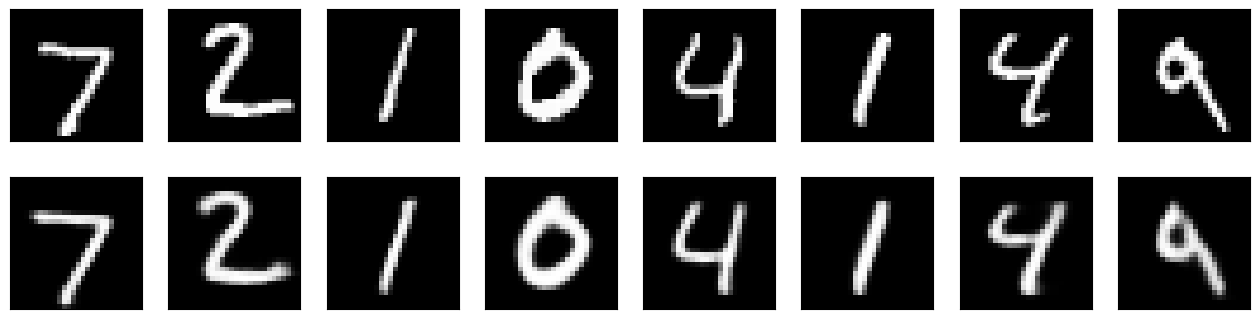

In [7]:
# Evaluate reconstruction
test_dataset = datasets.MNIST(
    root='./data', train=False,
    transform=transform, download=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    images, _ = batch
    images = images.to(device)
    x_recon, _, _ = model(images)
    x_recon = x_recon.cpu()
    images = images.cpu()
    # Plot original and reconstructed images
    n = 8
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Sampled shape: torch.Size([16, 1, 28, 28]) (1.0336453315796101e-24, 0.9986562728881836)


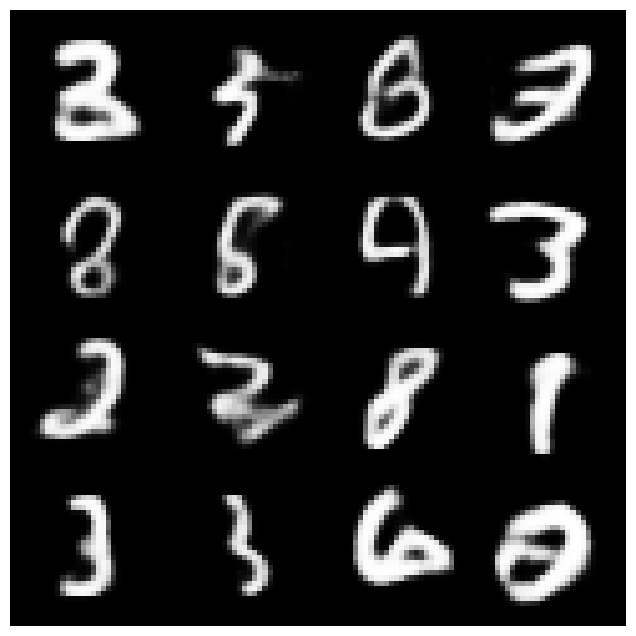

In [8]:
# sample from the trained model
model.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    samples = model.decode(z)
print(f"Sampled shape: {samples.shape} {(samples.min().item(), samples.max().item())}")
samples = torch.sigmoid(samples).cpu()
samples = samples.cpu()

# display the samples
grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray_r')
plt.axis('off')
plt.show()

Interpolated shape: torch.Size([10, 1, 28, 28])


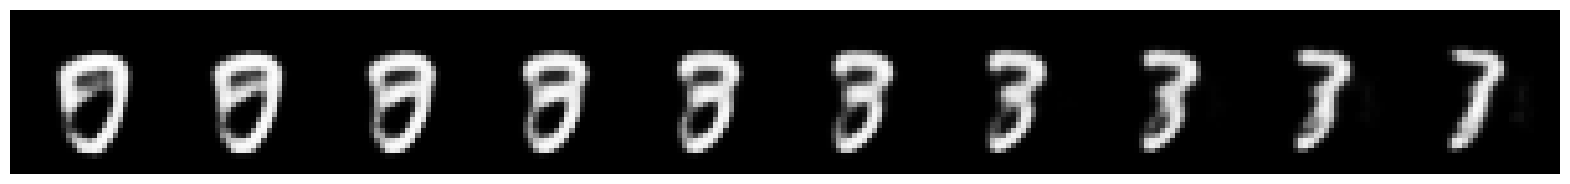

In [ ]:
# latent space interpolation
model.eval()
with torch.no_grad():
    z1 = torch.randn(1, 20).to(device)
    z2 = torch.randn(1, 20).to(device)
    n_steps = 10
    interpolated = []
    for alpha in torch.linspace(0, 1, n_steps):
        z = (1 - alpha) * z1 + alpha * z2
        sample = model.decode(z)
        interpolated.append(sample.cpu())
    interpolated = torch.cat(interpolated, dim=0)
print(f"Interpolated shape: {interpolated.shape}")
# display the interpolated samples
grid = torchvision.utils.make_grid(interpolated, nrow=n_steps, normalize=True)
plt.figure(figsize=(20, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray_r')
plt.axis('off')
plt.show()